# Preprocessing

### Fragestellung  
Thema der Projektarbeit ist die Vorhersage der Position eines Flugzeugs mittels ADS-B (automatic dependent surveillance–broadcast protocol) -Daten. Dabei soll sich auf einen Zielprameter beschräkt werden. Im Fall des vorliegenden Projektes ist das der **Breitengrad (Latitude)**. Ziel des Preojektes ist es, die beste maschinelle Lernmethode zur Vorhersage des Breitengrades zu finden. Dabei handelt es sich um ein Regressionsproblem.

In [14]:
import pandas as pd
from sklearn import preprocessing
import json
import matplotlib.pyplot as plt
import seaborn as sns

###  1. Bestimmen Sie folgende Eigenschaften des Datensatzes: Anzahl Samples, Anzahl Features, Skalen der Features (nominal/ordinal/metrisch), Häufigkeit fehlender Werte, ggf. Zielparameter.

In [15]:
training_file = '../data/training_5_category_1/training_5_category_1.csv'
training = pd.read_csv(training_file, index_col=0)

/Users/miriamamin/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [16]:
training.head()

timeAtServer  aircraft   latitude  longitude  baroAltitude  geoAltitude  \
id                                                                            
1          0.000      1526  50.174188   5.035970      10774.68     11140.44   
2          0.000      1293  60.574610  11.334948       6941.82      6911.34   
3          0.001      2190  46.497911   6.754051      11277.60     11658.60   
4          0.003       495  50.035602   8.749868      11879.58     12298.68   
5          0.005       149  47.648450  10.952454       6644.64      6918.96   

    numMeasurements                              measurements  
id                                                             
1                 2    [[115,916424593,79],[13,916077078,50]]  
2                 2   [[121,975844453,55],[253,975950656,51]]  
3                 2  [[112,975427734,107],[206,975920296,81]]  
4                 2   [[110,981978250,50],[394,982535968,33]]  
5                 2   [[188,979898250,61],[131,979958890,84]]

In [17]:
print(training.columns)
print('Anzahl Samples: ' + str(training.shape[0]))
print('Anzahl Features: ' + str(training.shape[1]))

Index(['timeAtServer', 'aircraft', 'latitude', 'longitude', 'baroAltitude',
       'geoAltitude', 'numMeasurements', 'measurements'],
      dtype='object')
Anzahl Samples: 1951877
Anzahl Features: 8


In [18]:
sensors_file = '../data/training_5_category_1/sensors.csv'
sensors = pd.read_csv(sensors_file, index_col=0)
sensors.index.name='id'
print(sensors.columns)
print('Anzahl Samples (Sensoren): ' + str(sensors.shape[0]))
print('Anzahl Features (Sensoren): ' + str(sensors.shape[1]))

Index(['latitude', 'longitude', 'height', 'type'], dtype='object')
Anzahl Samples (Sensoren): 523
Anzahl Features (Sensoren): 4


#### Anzahl Samples und Features, Skalen der Features

Der Datensatz hat 1.951.877 Samples und 8 Features:
  
`'timeAtServer', 'aircraft', 'latitude', 'longitude', 'baroAltitude', 'geoAltitude', 'numMeasurements', 'measurements'`
         
wobei in der Spalte 'Measurements' noch weitere (Meta-)Features über die Messung verschachtelt sind: `SensorID, Messzeitpunkt, FlugzeugID.` 
SensorID lässt in sensor.csv über die ID wiederfinden, wodurch noch die Features `'latitude', 'longitude', 'height', 'type'` verschachtelt sind. Der Sensordatensatz hat 523 Samples und 4 Features. 

**Trainings-Datensatz:**
* id: a unique ID for each transponder transmission. This ID can be used to refer to specific measurements in the results file. *nominal*
* timeAtServer: timestamp denoting the time when the measurement arrived at OpenSky’s server. Unit is seconds and it starts at timeAtServer=0 in each data set. *metrisch*
* aircraft: a randomized ID of the aircraft which sent the position report. *nominal*
* latitude: latitude reported by the aircraft in decimal degrees. This column is null for those positions which should be determined by the localization algorithm. *metrisch*
* longitude: longitude reported by the aircraft in decimal degrees. This column is null for those positions which should be determined by the localization algorithm. *metrisch*
* baroAltitude: barometric altitude reported by the aircraft in meters. *metrisch*
* geoAltitude: geometric (GPS) height reported by the aircraft in meters. This column is null for those positions which should be determined by the localization algorithm. *metrisch*
* numMeasurements: redundant field indicating the number of sensors which recorded the position report. *metrisch*
* measurements: JSON array of triples [sensorID, timestamp, signalstrength].
* serial: unique sensor ID which can be matched with the sensor information table (sensors data table below). *nominal*
* timestamp: precise timestamp for the detection of the position report at the sensor in nanoseconds. *metrisch*
* signalstrength: indicator of the strength of the report’s signal at the sensor (often in dB). *metrisch*

**Sensor-Datensatz:**
* latitude/longitude: wie im Trainingsdatenatz *metrisch*
* height: Höhe des Sensors *metrisch*
* type: the type of hard- and software of the sensor *nominal*
  
  Quelle: https://competition.opensky-network.org/documentation.html
  
Als Zielvariable würden sich `'latitude', 'longitude', 'geoAltitude'` anbieten


Insgesamt stammen die Daten von 1514 Flugzeugen

In [19]:
print('Anzahl verschiedener Flugzeuge: ' + str(len((training['aircraft'].unique()))))

Anzahl verschiedener Flugzeuge: 1514


#### Häufigket fehlender Werte

In den Trainingsdaten gibt es 112.289 Zeilen mit fehlendern Werten, in den Sensordaten keine.

In [20]:
datasets= {'Trainingsdaten':training, 'Sensordaten':sensors}
for k,v in datasets.items():
    is_NaN = v.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    rows_with_NaN = v[row_has_NaN]
    print('Fehlende Werte in ' + k + ': ' + str(rows_with_NaN.shape[0]))

Fehlende Werte in Trainingsdaten: 112289
Fehlende Werte in Sensordaten: 0


### 2. Falls es nicht-numerische Features gibt: Wandeln Sie diese in ein ML-geeignetes Format um.

In den Datensätzen gibt es zwei Features, die nicht numerisch sind und umgewandelt werden müssen:  
`measurements` im Traimingsdatensatz und `type` im Sensordatensatz. 

Beim nicht-numerischen Wert `type` im Sensordatensatz handelt es sich um einen String. Ich werde ihn mitteln sklearns LabelEncode in ein numerisches Label umwandeln.  


In [21]:
le = preprocessing.LabelEncoder()
sensors['type'] = le.fit_transform(sensors['type'].values)

Bei `measurements` handelt es sich um einen string, der aber aussieht, wie ein Array von Arrays von Integers. Um diese Spalte zu kodieren, gehen ich folgendermaßen vor: 
1. String als Array von Array von Integers parsen
2. Nur die 2 Measurements mit der besten Signalstärke behalten
3. Die jeweiligen Werte in je eine eigene Spalte überführen
4. Die Sensordaten hinzufügen
  
Ich habe mich dazu entschlossen, nur die beiden Messungen mit den beiden Signalstärken zu betrachten. Eine uneinheitliche Anzahl an Messungen unter den Signalen könnte zu Bias im maschinellen Lernen führen. 
Ein anderer Wert als 2 hätte folglich dazu geführt, dass ca. 50% des Datensatzes nicht mehr verwendet werden könnte. Zwei schien mir daher als der beste Wert.

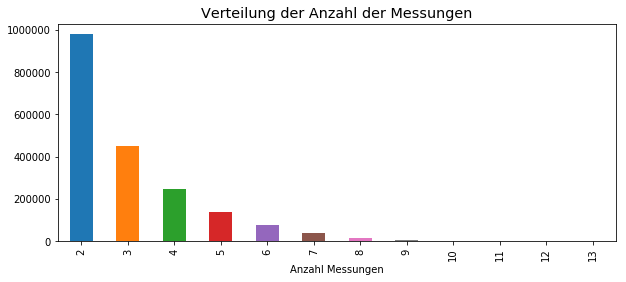

In [22]:
f = plt.figure(figsize=(10,4))
plt.xlabel('Anzahl Messungen')
plt.rc('font', size=12)
plt.title('Verteilung der Anzahl der Messungen')
training['numMeasurements'].value_counts().plot(kind='bar')
f.savefig('../Dokumentation/Abbildungen/measurements_histo.png')

In [23]:
# parse as list of list of ints
training['measurements']=training['measurements'].apply(lambda x: json.loads(x))

# filter for top 2 singal strength
def find_top_two_signals(x):
    sorted_measurements = sorted(x,key=lambda x: x[2], reverse=True)
    top_2_measurements=sorted_measurements[:2]
    return top_2_measurements

training['measurements']=training['measurements'].apply(lambda x: find_top_two_signals(x))

# measurements array in 2 Spalten aufsplitten und danach die einzelnen Werte in eigene Spalten übertragen
measurements_df = pd.DataFrame(training["measurements"].values.tolist(),columns=['sensor1','sensor2'])
temp = pd.concat(
    [
        pd.DataFrame(measurements_df["sensor1"].values.tolist(),columns=['serial_1','timestamp_1','signalstrength_1']),
        pd.DataFrame(measurements_df["sensor2"].values.tolist(),columns=['serial_2','timestamp_2','signalstrength_2'])
    ], axis=1
)
temp.index +=1
training_measurements = pd.concat([training,temp], axis = 1)
training_measurements = training_measurements.rename(columns={'latitude':'latitude_aircraft',
                                                              'longitude':'longitude_aircraft'})
# save sensor ids as column
sensors['serial'] = sensors.index.tolist()

# merge sensors data into training data
#sensor 1
merged_df_1 = pd.merge(left = training_measurements, right = sensors, how='left',
                     left_on = 'serial_1', right_on='serial')
merged_df_1 = merged_df_1.rename(columns={'height':'height_1','type':'type_1','serial':'serial_1_x',
                                         'latitude':'latitude_sensor_1','longitude':'longitude_sensor_1'})
#sensor 2
merged_df_2 = pd.merge(left = merged_df_1, right = sensors, how='left',
                     left_on = 'serial_2', right_on='serial')
merged_df_2 = merged_df_2.rename(columns={'height':'height_2','type':'type_2','serial':'serial_2_x',
                                         'latitude':'latitude_sensor_2','longitude':'longitude_sensor_2'})

# drop unneccesarry columns
training_final = merged_df_2.drop(['serial_1_x','serial_2_x', 'measurements','numMeasurements'], axis=1)
training_final= training_final.rename(columns={'latitude_aircraft':'latitude',
                                                              'longitude_aircraft':'longitude'})

### 3. Falls es Missing Values gibt: Finden Sie eine Lösung und wenden Sie diese an. Begründen Sie.

Im Trainings-Datensatz gibt es insgesamt 112.289 Zeilen mit fehlenden Werten.

In [24]:
is_NaN = training_final.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = training_final[row_has_NaN]

print('Fehlende Werte im Trainingsdatensatz: ' + str(rows_with_NaN.shape[0]))

Fehlende Werte im Trainingsdatensatz: 112289


Diese fehlenden Werte sind folgendermaßen auf die Spalten aufgeteilt:

In [25]:
for column in training_final.columns:
    print(column + ': '+ str(training_final[column].isnull().sum()))

timeAtServer: 0
aircraft: 0
latitude: 112289
longitude: 112289
baroAltitude: 0
geoAltitude: 112289
serial_1: 0
timestamp_1: 0
signalstrength_1: 0
serial_2: 0
timestamp_2: 0
signalstrength_2: 0
latitude_sensor_1: 0
longitude_sensor_1: 0
height_1: 0
type_1: 0
latitude_sensor_2: 0
longitude_sensor_2: 0
height_2: 0
type_2: 0


Wie man sieht, fehlen nur Werte in den Spalten `latitude, longitude, geoAltitude`. Da diese ohnehin die Zielvariablen darstellen, werde ich diese Spalten löschen. Später könnte man sie jedoch als test-datensatz verwenden. Darum speichere ich zwei Versionen der Daten: Einmal mit und einmal ohne fehlende Werte. 

In [26]:
training_final.to_csv('../data/trining_data_preprocesed_with_nans.csv')
training_final = training_final.dropna(axis=0)
training_final.to_csv('../data/training_data_preprocessed.csv')

/Users/miriamamin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


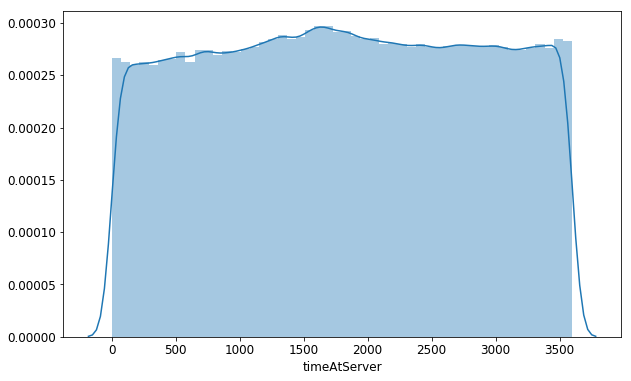

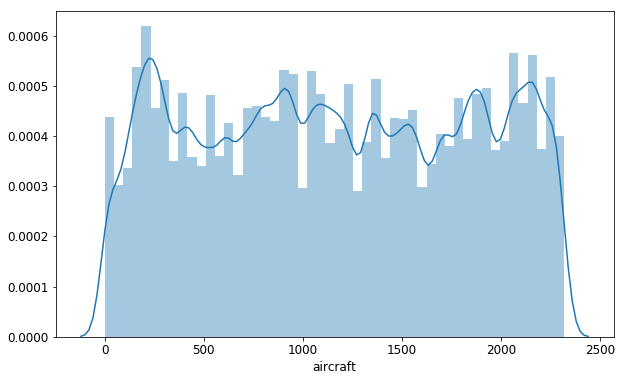

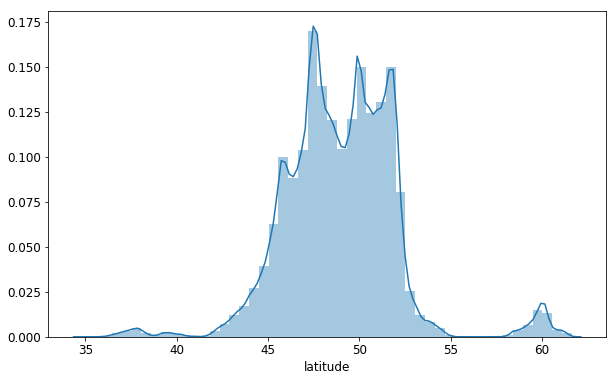

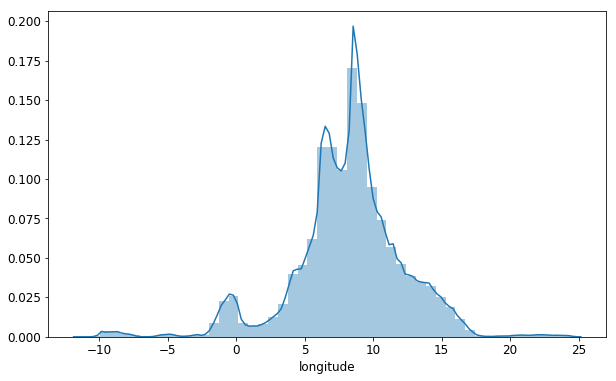

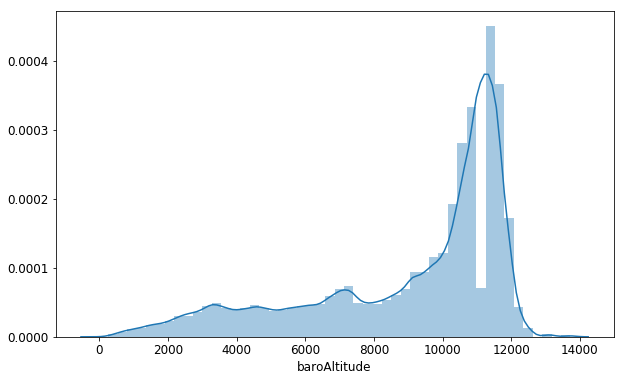

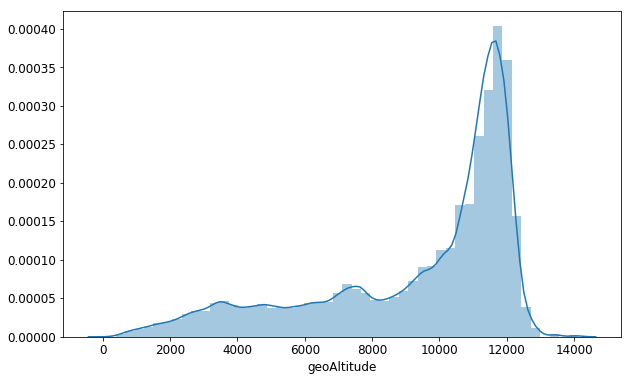

In [31]:
plot_cols = ['timeAtServer', 'aircraft', 'latitude', 'longitude', 'baroAltitude',
       'geoAltitude']
for col in plot_cols:
    plt.figure(figsize=(10,6))
    sns.distplot(training_final[col])
    plt.show

### 4. Charakterisieren Sie alle Features hinsichtlich ihrer enthaltenen Werte (deskriptive Statistik).

Die folgende Zelle enthält eine deskriptive Beschreibung aller Werte in den Daten.

In [127]:
stats = training_final.describe()
stats = stats.round(2)
stats

timeAtServer    aircraft    latitude   longitude  baroAltitude  \
count    1839588.00  1839588.00  1839588.00  1839588.00    1839588.00   
mean        1814.64     1165.95       48.96        8.19       9043.15   
std         1029.52      675.87        3.10        4.01       2908.24   
min            0.00        1.00       34.85      -11.38        -15.24   
25%          937.66      588.00       47.11        6.35       7307.58   
50%         1812.01     1148.00       48.90        8.46      10363.20   
75%         2700.96     1769.00       50.89       10.27      11277.60   
max         3599.97     2319.00       61.64       24.65      13723.62   

       geoAltitude    serial_1   timestamp_1  signalstrength_1    serial_2  \
count   1839588.00  1839588.00  1.839588e+06        1839588.00  1839588.00   
mean       9354.89      192.41  1.815623e+12             93.28      199.27   
std        2972.27      125.19  1.029518e+12             30.04      132.50   
min         106.68       10.00  7.616059e+08              0.00       10.00   
25%        7597.14      113.00  9.386394e+11             71.00      114.00   
50%       10721.34      130.00  1.812997e+12             93.00      131.00   
75%       11620.50      289.00  2.701936e+12            115.00      289.00   
max       14112.24      477.00  3.600961e+12            255.00      477.00   

        timestamp_2  signalstrength_2  latitude_sensor_1  longitude_sensor_1  \
count  1.839588e+06        1839588.00         1839588.00          1839588.00   
mean   1.815624e+12             65.60              49.03                8.23   
std    1.029518e+12             28.12               2.97                3.88   
min    8.303391e+08              0.00              37.17               -9.35   
25%    9.386394e+11             44.00              47.25                6.68   
50%    1.812997e+12             64.00              48.37                8.49   
75%    2.701940e+12             86.00              51.24               10.28   
max    3.601255e+12            189.00              60.19               24.83   

         height_1      type_1  latitude_sensor_2  longitude_sensor_2  \
count  1839588.00  1839588.00         1839588.00          1839588.00   
mean       370.27        2.98              48.95                8.39   
std        371.89        0.13               2.96                3.90   
min         -1.82        2.00              37.17               -9.35   
25%         43.90        3.00              47.25                7.35   
50%        302.88        3.00              48.37                8.49   
75%        529.39        3.00              50.94               10.23   
max       1699.39        3.00              60.19               24.83   

         height_2      type_2  
count  1839588.00  1839588.00  
mean       363.51        2.92  
std        343.36        0.26  
min         -1.82        2.00  
25%         92.62        3.00  
50%        277.02        3.00  
75%        502.70        3.00  
max       1699.39        3.00

Hier noch einmal in der Darstellung als Boxplot. Die Timestamps werden dabei in einem eigenen Graphen dargestellt, da sie eine weit größere Range als der Rest der Daten haben.

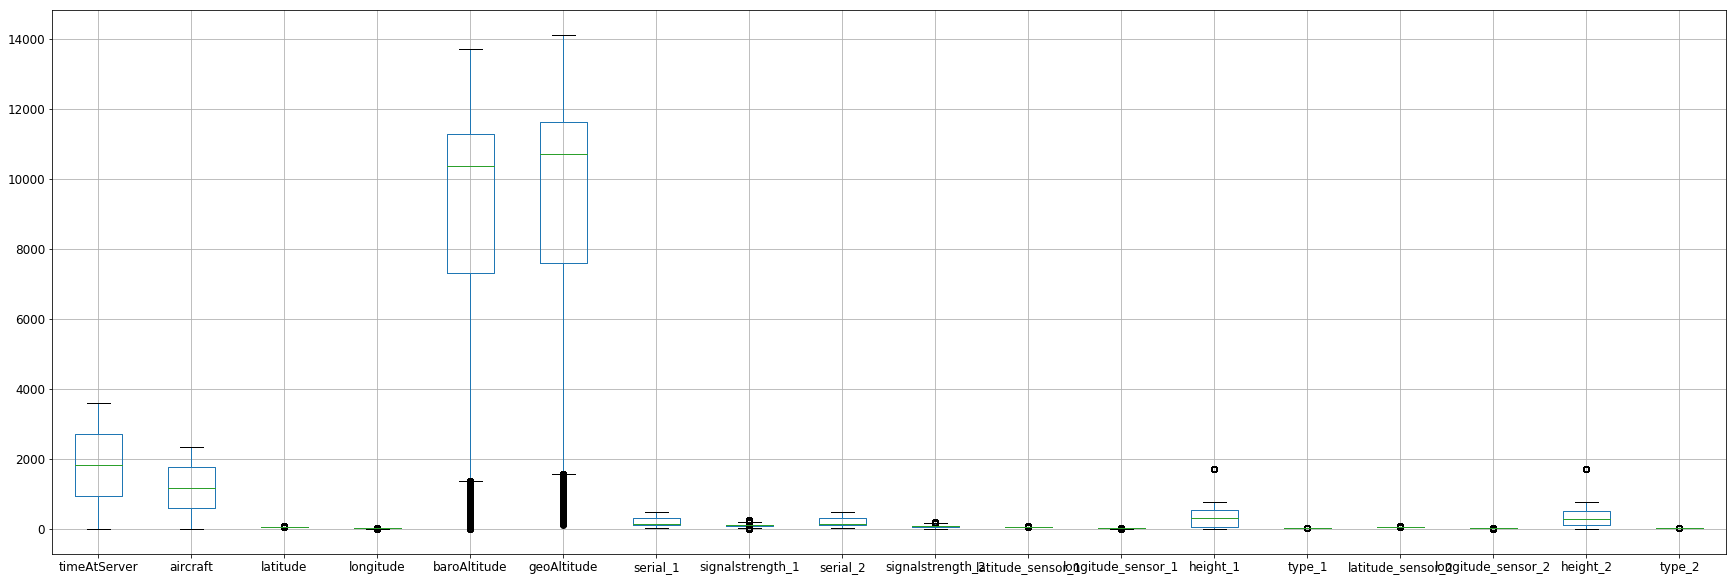

In [128]:
cols_without_timestamps = ['timeAtServer', 'aircraft', 'latitude', 'longitude', 'baroAltitude',
       'geoAltitude', 'serial_1', 'signalstrength_1',
       'serial_2', 'signalstrength_2', 'latitude_sensor_1',
       'longitude_sensor_1', 'height_1', 'type_1', 'latitude_sensor_2',
       'longitude_sensor_2', 'height_2', 'type_2']
plt.figure(figsize=(30,10))
training_final[cols_without_timestamps].boxplot()

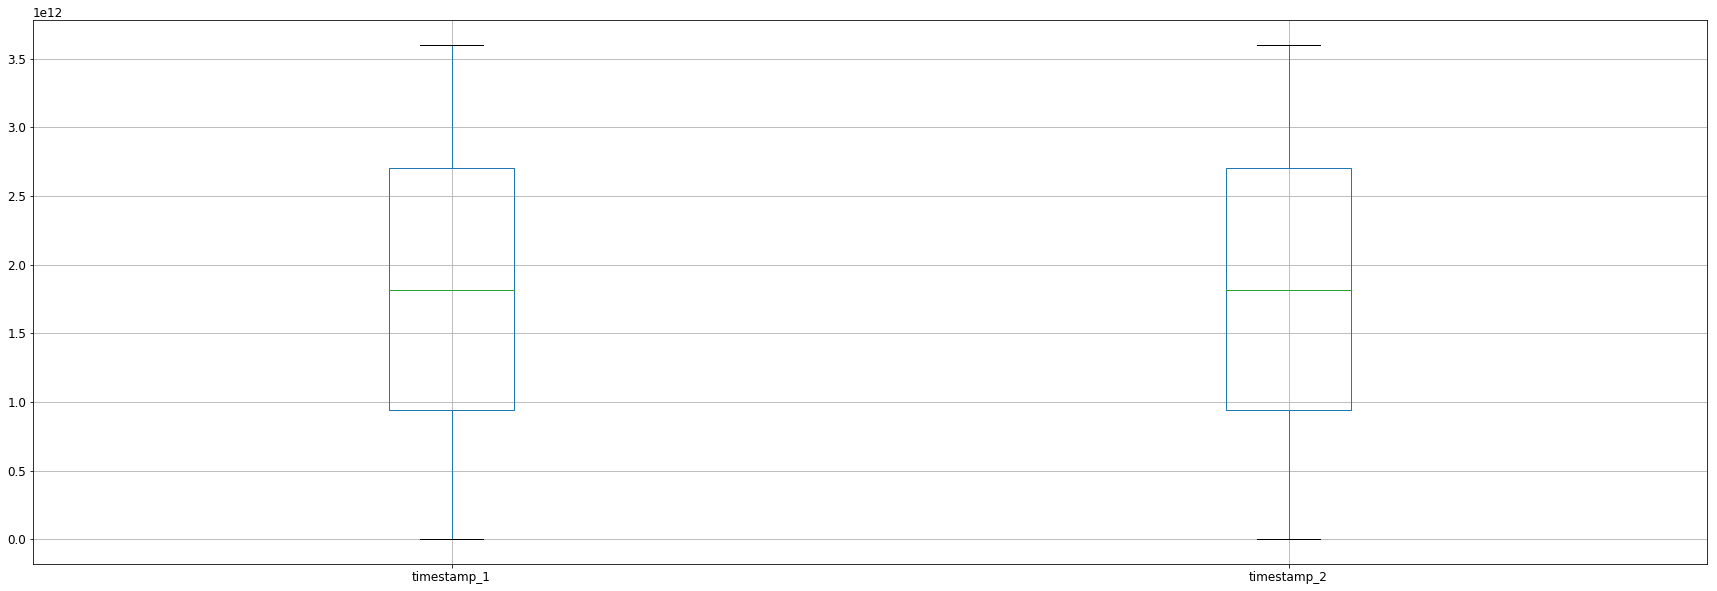

In [129]:
cols_with_timestamps = ['timestamp_1', 'timestamp_2']
plt.figure(figsize=(30,10))
training_final[cols_with_timestamps].boxplot()

### 5. Ist der Datensatz nun für überwachtes/ unüberwachtes Lernen geeignet? Begründen Sie.

Der Datensatz ist definitv für überwachtes Lernen geeignet. Er kann dafür verwendet werden. Insbesondere mithilfe der Sensordaten kann ein Algorithmus trainiert werden, der den Höhen- und Breitengrad, sowie die Höhe (geoAltitude) vorhersagt.  
Teile des Datensatzes könnten auch für unüberwachtes Leren verwendet werden, beispielsweie ein Clustering der Sensoren.